In [64]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import History

In [6]:
df = pd.read_csv("train.csv")
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
df.shape

(1017209, 9)

In [8]:
store = pd.read_csv("store.csv")
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
store.shape

(1115, 10)

### Data Dictionary
        • Store: a unique ID for each store
        • Sales: the turnover for a given day (our target y variable)
        • Customers: the number of customers on a given day
        • Open: an indicator for whether the store was open:0 = closed, 1 = open
        • StateHoliday: indicates a state holiday. Normally
        all stores, with few exceptions, are closed on state
        holidays. Note that all schools are closed on public
        holidays and weekends. a = public holiday, b = Easter
        holiday, c = Christmas, 0 = none
        • SchoolHoliday: indicates if the (Store, Date) was
        affected by the closure of public schools
        • StoreType: differentiates between four different store
        models: a, b, c, d
        • Assortment: describes an assortment level: a = basic,
        b = extra, c = extended
        • CompetitionDistance: distance in meters to the
        nearest competitor store
        • CompetitionOpenSince[Month/Year]: gives the
        approximate year and month of the time the nearest
        competitor was opened
        • Promo: indicates whether a store is running a promo
        on that day
        • Promo2: Promo2 is a continuing and consecutive
        promotion for some stores: 0 = store is not
        participating, 1 = store is participating
        • Promo2Since[Year/Week]: describes the year and
        calendar week when the store started participating in
        Promo2
        • PromoInterval: describes the consecutive intervals
        at which Promo2 is started, naming the months the
        promotion is started anew (e.g., “Feb, May, Aug, Nov”
        means each round starts in February, May, August, and
        November of any given year for that store)


In [11]:
df_new = df.merge(store, on=["Store"], how="inner")
df_new.shape

(1017209, 18)

In [13]:
df_new.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [17]:
df_new["DayOfWeek"].value_counts()

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

In [20]:
df_new['Date'] = pd.to_datetime(df_new['Date'], infer_datetime_format=True)
df_new["Month"] = df_new["Date"].dt.month
df_new["Quarter"] = df_new["Date"].dt.quarter
df_new["Year"] = df_new["Date"].dt.year
df_new["Day"] = df_new["Date"].dt.day
df_new["Week"] = df_new["Date"].dt.week
df_new["Season"] = np.where(df_new["Month"].isin([3,4,5]),"Spring",
                            np.where(df_new["Month"].isin([6,7,8]),"Summer",
                                     np.where(df_new["Month"].isin([9,10,11]),"Fall",
                                              np.where(df_new["Month"].isin([12,1,2]),"Winter","None"))))

In [21]:
df_new[["Date","Year","Month","Day","Week","Quarter","Season"]].head()

,Date,Year,Month,Day,Week,Quarter,Season
0,2015-07-31,2015,7,31,31,3,Summer
1,2015-07-30,2015,7,30,31,3,Summer
2,2015-07-29,2015,7,29,31,3,Summer
3,2015-07-28,2015,7,28,31,3,Summer
4,2015-07-27,2015,7,27,31,3,Summer


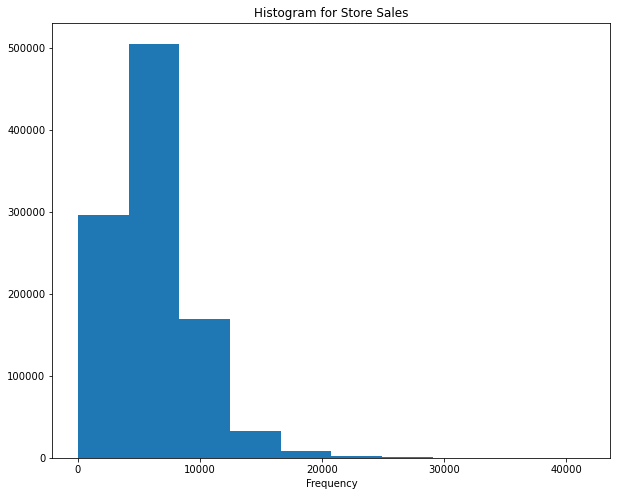

In [25]:
plt.figure(figsize=(10,8))
plt.hist(df_new["Sales"])
plt.title("Histogram for Store Sales")
plt.xlabel("Frequency")
plt.show()

The histogram helps us understand the distribution of the data at a
high level. From the preceding plot, we can see that the data range is from
0 to 40,000, but there is barely any data after 20,000. This indicates that
most of the stores have sales in the range 0–20,000, and just a few stores
have sales greater than 20,000.

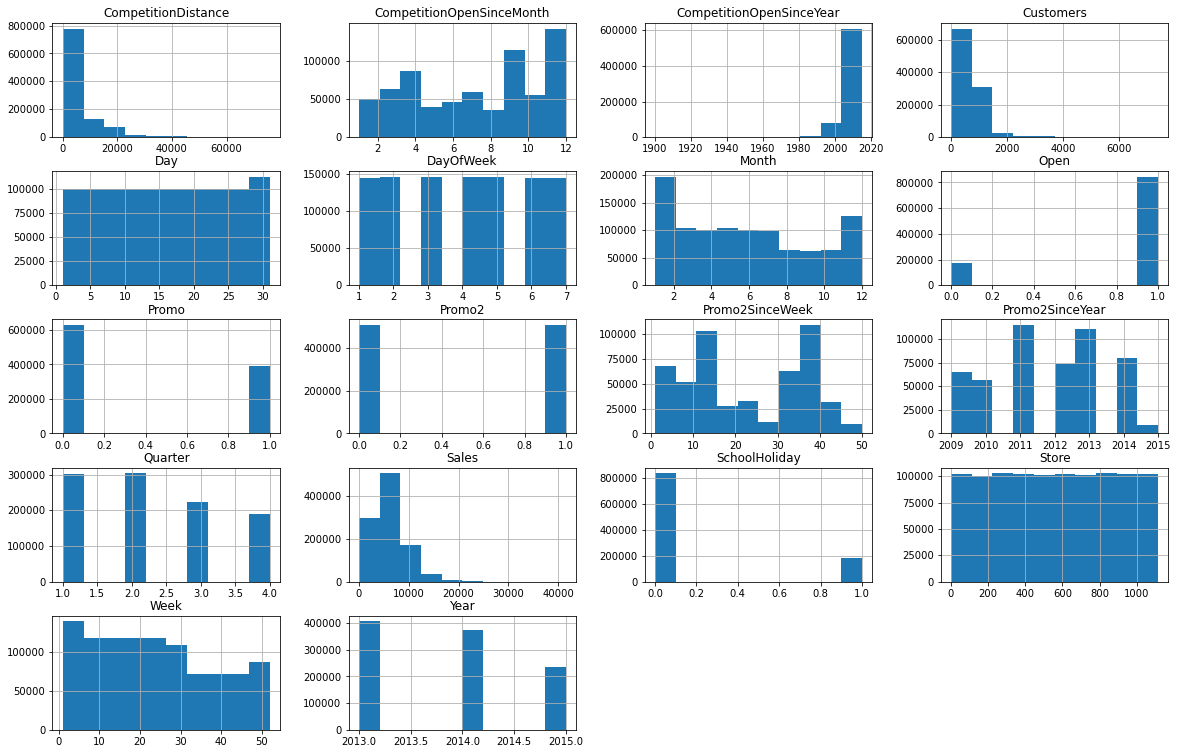

In [29]:
df_new.hist(figsize=(20,13));

In [30]:
df_new.isnull().sum()/df_new.shape[0] * 100

Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
Month                         0.000000
Quarter                       0.000000
Year                          0.000000
Day                           0.000000
Week                          0.000000
Season                        0.000000
dtype: float64

We can see that Promo2SinceWeek,
Promo2SinceYear, PromoInterval, CompetitionOpenSinceMonth, and
CompetitionOpenSinceYear have over 30% null values. This is a big
loss and there is nothing much we can do to fix this.**As a rule of thumb, if there is a loss of anything between 0% and 10%, we can make a few attempts to fill the missing points and use the feature.**

In [33]:
df_new["CompetitionDistance"]=df_new["CompetitionDistance"].fillna(df_new["CompetitionDistance"].mode()[0])

In [34]:
df_new["CompetitionDistance"].isnull().sum()/df_new.shape[0] * 100

0.0

### Categorical Features 

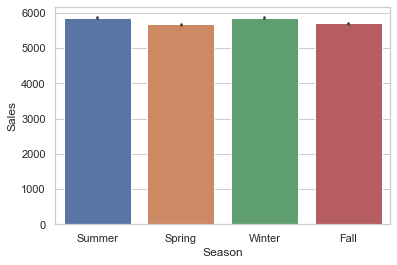

In [37]:
sns.set(style="whitegrid")
ax = sns.barplot(x="Season", y="Sales", data=df_new)

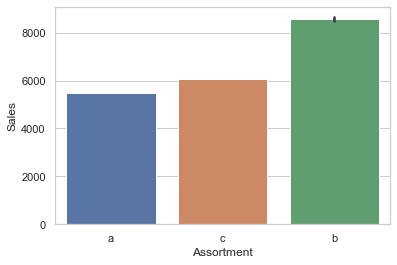

In [38]:
ax = sns.barplot(x="Assortment", y="Sales", data=df_new)

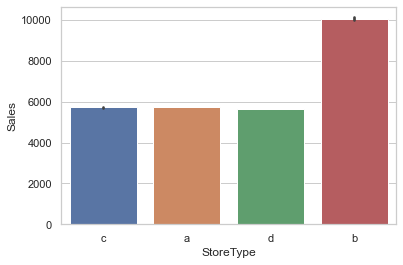

In [39]:
ax = sns.barplot(x="StoreType", y="Sales", data=df_new)

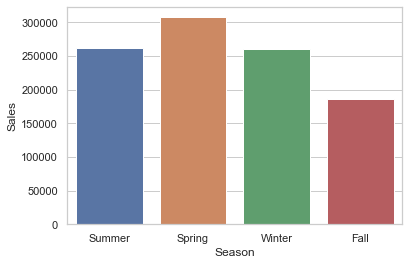

In [40]:
ax = sns.barplot(x="Season", y="Sales", data=df_new,estimator=np.size)

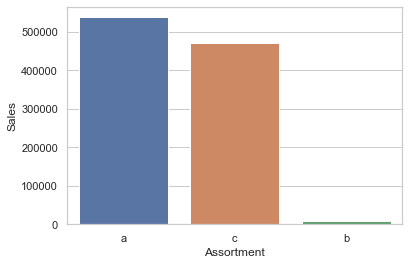

In [42]:
ax = sns.barplot(x="Assortment", y="Sales", data=df_new, estimator=np.size)

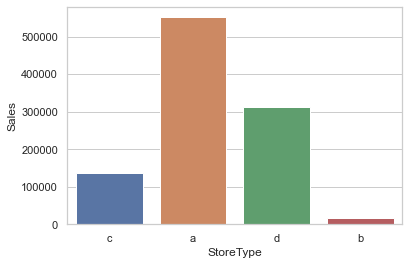

In [43]:
ax = sns.barplot(x="StoreType", y="Sales", data=df_new, estimator=np.size)

### Data Engineering

In [45]:
target = ["Sales"]
numeric_columns = ["Customers","Open","Promo","Promo2","StateHoliday","SchoolHoliday","CompetitionDistance"]
categorical_columns = ["DayOfWeek","Quarter","Month","Year","StoreType","Assortment","Season"]

In [46]:
def create_ohe(df, col):
    le = LabelEncoder()
    a=le.fit_transform(df_new[col]).reshape(-1,1)
    ohe = OneHotEncoder(sparse=False)
    column_names = [col+ "_"+ str(i) for i in le.classes_]
    return(pd.DataFrame(ohe.fit_transform(a),columns =column_names))

In [47]:
temp = df_new[numeric_columns]
for column in categorical_columns:
    temp_df = create_ohe(df_new,column)
    temp = pd.concat([temp,temp_df],axis=1)

In [48]:
print("Shape of Data:",temp.shape)
print("Distinct Datatypes:",temp.dtypes.unique())

Shape of Data: (1017209, 44)
Distinct Datatypes: [dtype('int64') dtype('O') dtype('float64')]


In [49]:
temp["StateHoliday"].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

**StateHoliday** feature seems to have incorrect values. Ideally, StateHoliday
should have either a 0 or 1 as the possible values to indicate whether it is a
holiday or not. Let’s repair the feature by replacing all values of “a,” “b,” and
“c” with 1 and the rest with 0, therefore converting the variable as numeric.

In [50]:
temp["StateHoliday"]= np.where(temp["StateHoliday"]== '0',0,1)
temp.dtypes.unique()

array([dtype('int64'), dtype('int32'), dtype('float64')], dtype=object)

In [53]:
x_train, x_test, y_train, y_test = train_test_split(temp,df_new[target],test_size=0.2,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=42)

In [54]:
print("Shape of x_train:",x_train.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_val:",y_val.shape)
print("Shape of y_test:",y_test.shape)

Shape of x_train: (732390, 44)
Shape of x_val: (81377, 44)
Shape of x_test: (203442, 44)
Shape of y_train: (732390, 1)
Shape of y_val: (81377, 1)
Shape of y_test: (203442, 1)


### Create Deep Neural Network Architecture

In [56]:
model = Sequential()
model.add(Dense(150,input_dim=44,activation="relu"))
model.add(Dense(1,activation="linear"))

In [57]:
model.compile(optimizer='adam',loss="mean_absolute_error",
              metrics=["mean_absolute_error"])

In [59]:
model.fit(x_train.values,y_train.values, 
          validation_data=(x_val,y_val),
          epochs=10,
          batch_size=64)

Train on 732390 samples, validate on 81377 samples
Epoch 1/10
732390/732390 [==============================] - 13s 18us/step - loss: 960.8412 - mean_absolute_error: 960.8422 - val_loss: 834.5015 - val_mean_absolute_error: 834.5015
Epoch 2/10
732390/732390 [==============================] - 14s 19us/step - loss: 791.5286 - mean_absolute_error: 791.5278 - val_loss: 754.7638 - val_mean_absolute_error: 754.7641
Epoch 3/10
732390/732390 [==============================] - 13s 18us/step - loss: 744.8002 - mean_absolute_error: 744.8001 - val_loss: 739.2835 - val_mean_absolute_error: 739.2836
Epoch 4/10
732390/732390 [==============================] - 13s 17us/step - loss: 725.0981 - mean_absolute_error: 725.0984 - val_loss: 720.5270 - val_mean_absolute_error: 720.5273
Epoch 5/10
732390/732390 [==============================] - 13s 18us/step - loss: 712.3222 - mean_absolute_error: 712.3218 - val_loss: 697.4841 - val_mean_absolute_error: 697.4847
Epoch 6/10
732390/732390 [=======================

### Testin Model Performance

In [60]:
result = model.evaluate(x_test.values,y_test.values)

203442/203442 [==============================] - 2s 12us/step


In [61]:
for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

Metric  loss : 679.76
Metric  mean_absolute_error : 679.76


### Improve The Model

In [63]:
model = Sequential()

model.add(Dense(150,input_dim = 44,activation="relu"))
model.add(Dense(150,activation="relu"))
model.add(Dense(150,activation="relu"))
model.add(Dense(1,activation = "linear"))

model.compile(optimizer='adam',
              loss="mean_squared_error",
              metrics=["mean_absolute_error"])

history = model.fit(x_train.values,y_train.values,
                    validation_data=(x_val,y_val),
                    epochs=10,batch_size=64)

result = model.evaluate(x_test.values,y_test.values)
for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

Train on 732390 samples, validate on 81377 samples
Epoch 1/10
732390/732390 [==============================] - 21s 28us/step - loss: 1734454.1466 - mean_absolute_error: 855.1801 - val_loss: 1184318.5936 - val_mean_absolute_error: 721.0903
Epoch 2/10
732390/732390 [==============================] - 21s 28us/step - loss: 1147553.5828 - mean_absolute_error: 719.3922 - val_loss: 1045118.3569 - val_mean_absolute_error: 680.5428
Epoch 3/10
732390/732390 [==============================] - 21s 28us/step - loss: 1074154.5996 - mean_absolute_error: 695.4686 - val_loss: 1013160.8988 - val_mean_absolute_error: 680.6748
Epoch 4/10
732390/732390 [==============================] - 21s 29us/step - loss: 1045074.8093 - mean_absolute_error: 686.1059 - val_loss: 964464.4978 - val_mean_absolute_error: 660.0650
Epoch 5/10
732390/732390 [==============================] - 21s 28us/step - loss: 1024459.5732 - mean_absolute_error: 679.5262 - val_loss: 1120780.2363 - val_mean_absolute_error: 734.0583
Epoch 6/10

In [65]:
from keras.callbacks import History

history = History()

model = Sequential()
model.add(Dense(350,input_dim = 44,activation="relu"))
model.add(Dense(350,activation="relu"))
model.add(Dense(350,activation="relu"))
model.add(Dense(350,activation="relu"))
model.add(Dense(350,activation="relu"))
model.add(Dense(1,activation = "linear"))

model.compile(optimizer='adam',
              loss="mean_squared_error",
              metrics=["mean_absolute_error"])

model.fit(x_train.values,y_train.values,
          validation_data=(x_val,y_val),
          epochs=15,batch_size=64,
          callbacks=[history])

result = model.evaluate(x_test.values,y_test.values)
for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

Train on 732390 samples, validate on 81377 samples
Epoch 1/15
732390/732390 [==============================] - 76s 104us/step - loss: 1652623.4639 - mean_absolute_error: 843.1595 - val_loss: 1398274.4052 - val_mean_absolute_error: 778.5922
Epoch 2/15
732390/732390 [==============================] - 77s 105us/step - loss: 1179167.5102 - mean_absolute_error: 728.0594 - val_loss: 1190663.5799 - val_mean_absolute_error: 761.8058
Epoch 3/15
732390/732390 [==============================] - 75s 102us/step - loss: 1108452.9130 - mean_absolute_error: 705.0386 - val_loss: 1004141.9851 - val_mean_absolute_error: 676.6262
Epoch 4/15
732390/732390 [==============================] - 76s 103us/step - loss: 1065895.4717 - mean_absolute_error: 691.4215 - val_loss: 989109.9093 - val_mean_absolute_error: 664.4014
Epoch 5/15
732390/732390 [==============================] - 77s 105us/step - loss: 1040513.0861 - mean_absolute_error: 683.7864 - val_loss: 961560.7477 - val_mean_absolute_error: 660.6899
Epoch 

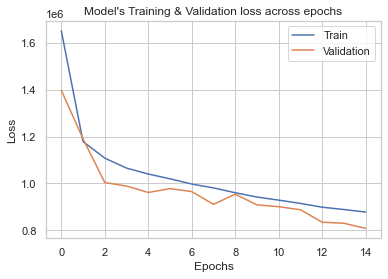

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()